In [1]:
import os
from pathlib import Path
from typing import Any
from pydantic import Field, BaseModel
import httpx

from grasp_agents import (
    BaseTool,
    LLMAgent,
    RunContext,
    ImageData,
    Printer,
    print_event_stream,
    ParallelProcessor,
)
from grasp_agents.openai import OpenAIReasoning
from grasp_agents.runner import Runner
from grasp_agents.typing.events import ProcPacketOutEvent
from grasp_agents.openai import OpenAIResponsesLLM, OpenAIResponsesLLMSettings
from grasp_agents.openai import OpenAIResponsesStreamOptionsParam
from grasp_agents.workflow.sequential_workflow import SequentialWorkflow
from grasp_agents.cloud_llm import APIProvider
from grasp_agents.rate_limiting import RateLimiter

from grasp_agents.telemetry.traceloop import init_traceloop

from grasp_agents.telemetry.phoenix import init_phoenix

In [2]:
PACKAGE_DIR = Path.cwd()

Paths to images used in the demo

In [3]:
IMG_1_URL = "https://www.simplilearn.com/ice9/free_resources_article_thumb/Expressions_In_C_2.PNG"
IMG_2_PATH = PACKAGE_DIR / "src/grasp_agents/examples/data/expr.jpeg"

Utils

In [4]:
def print_single_output(out: Any) -> None:
    print(f"\n<final answer>\n{out.payloads[0]}\n</final answer>")

**[Optional] Observability with Arize Phoenix (deployed locally via Docker)**

Start Phoenix locally:
```bash
cd ./phoenix
docker compose up -d  
docker compose logs -f phoenix
export PHOENIX_COLLECTOR_HTTP_ENDPOINT=http://localhost:6006/v1/traces # from docker-compose.yml
export TELEMETRY_PROJECT_NAME_KEY="openinference.project.name" # required by Phoenix
```

Open `http://localhost:6006/` (or the port you set in `docker-compose.yml`) in your browser to access the Phoenix UI.

Initialize telemetry

In [6]:
# Use Traceloop to produce spans (without sending them anywhere yet)
init_traceloop(project_name="agents-demo-10")

# Use Phoenix as the backend and UI for telemetry
# Alternatively, any OpenTelemetry-compatible backend can be used instead
init_phoenix(batch=False, use_litellm_instr=True, use_llm_provider_instr=False)

Traceloop exporting traces to a custom exporter

Metrics are disabled


## Simple generation with validated outputs

Output type validation

In [5]:
# list[int] is the output type used to validate the output
chatbot = LLMAgent[None, list[int], None](
    name="chatbot",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="minimal")
        ),
        max_response_retries=2,
    ),
)

# This initialises printer and usage tracker
ctx = RunContext[None](printer=Printer())

In [6]:
# Code block delimiters are stripped from the output
out = await chatbot.run(
    "Output a list of 3 integers from 0 to 10 as a python array, no talking",
    ctx=ctx,
)
print_single_output(out)

<chatbot> [ecce23_chatbot]
<input>
Output a list of 3 integers from 0 to 10 as a python array, no talking
</input>

[{'role': 'user', 'content': [ResponseInputText(text='Output a list of 3 integers from 0 to 10 as a python array, no talking', type='input_text')], 'type': 'message'}]
<chatbot> [ecce23_chatbot]
<response>
[
  3,
  7,
  1
]
</response>

------------------------------------
I/O/R/C tokens: 26/15/-/-


<final answer>
[3, 7, 1]
</final answer>


In [7]:
ctx.usage_tracker.usages

{'chatbot': Usage(input_tokens=26, output_tokens=15, reasoning_tokens=0, cached_tokens=None, cost=None)}

Completion data (e.g. log probs) per agent can be accessed via RunContext:

In [ ]:
# ctx.completions

In [8]:
# Stream thinking
chatbot = LLMAgent[None, str, None](
    name="chatbot",
    llm=OpenAIResponsesLLM(
        "gpt-5-mini",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low", summary="detailed"),
            stream_options=OpenAIResponsesStreamOptionsParam(include_usage=True),
        ),
    ),
    stream_llm_responses=True,
)
ctx = RunContext[None](printer=Printer())
async for event in print_event_stream(
    chatbot.run_stream(chat_inputs="tell me a joke", ctx=ctx)
):
    pass

<chatbot> [fc278b_chatbot]
<input>
tell me a joke
</input>


<chatbot> [fc278b_chatbot]
<input>
tell me a joke
</input>

<chatbot> [fc278b_chatbot]
<thinking>
**Preparing a joke**

The user just asked me to "tell me a joke," so I want to come up with a quick, clean, and witty one-liner or short joke. Hmm, a couple could be good in case the user wants more options. I’ll aim for concise material to keep it light and fun. I’m excited to share a laugh! Let’s see what I can come up with.
</thinking>

<chatbot> [fc278b_chatbot]
<response>
Why don't scientists trust atoms?

Because they make up everything. 

Want another one?
</response>
<chatbot> [fc278b_chatbot]
<thinking>
**Preparing a joke**

The user just asked me to "tell me a joke," so I want to come up with a quick, clean, and witty one-liner or short joke. Hmm, a couple could be good in case the user wants more options. I’ll aim for concise material to keep it light and fun. I’m excited to share a laugh! Let’s see what I can come up 

Streaming

In [9]:
chatbot = LLMAgent[None, list[int], None](
    name="chatbot",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5",
        llm_settings=OpenAIResponsesLLMSettings(
            # reasoning=OpenAIReasoning(effort="low", summary="detailed"),
        ),
    ),
    stream_llm_responses=True,
)
ctx = RunContext[None](printer=None)

In [10]:
async for event in print_event_stream(
    chatbot.run_stream(
        "Output a list of 30 integers from 0 to 10 as a python array. "
        "No code or talking.",
        ctx=ctx,
    )
):
    if isinstance(event, ProcPacketOutEvent):
        out = event.data


<chatbot> [0e9ff4_chatbot]
<input>
Output a list of 30 integers from 0 to 10 as a python array. No code or talking.
</input>

<chatbot> [0e9ff4_chatbot]
<response>
[0,1,2,3,4,5,6,7,8,9,10,0,1,2,3,4,5,6,7,8,9,10,0,1,2,3,4,5,6,7]
</response>

<chatbot> [0e9ff4_chatbot]
<processor output>
[
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7
]
</processor output>


In [11]:
ctx.usage_tracker.usages

{'chatbot': Usage(input_tokens=29, output_tokens=864, reasoning_tokens=768, cached_tokens=None, cost=None)}

Output type validation with structured outputs

In [11]:
# Some providers (e.g. `openai` and `gemini`) support structured outputs.
# With the OpenAI API, this will require a Pydantic model to validate the output.

from enum import StrEnum


class Selector(StrEnum):
    A = "A"
    B = "B"


class Response(BaseModel):
    result: list[int] = Field(..., description="3 random integers")
    value: Selector = Field(..., description="Choose a value randomly")


chatbot = LLMAgent[None, Response, None](
    name="chatbot",
    response_schema=Response,
    llm=OpenAIResponsesLLM(
        model_name="gpt-5",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
        apply_response_schema_via_provider=True,
    ),
)

# By default, response_schema is set to the output type of the agent (Response)
# In some cases, you may want to set it to a different type, e.g. when using
# custom output parsing.

ctx = RunContext[None](printer=Printer())

In [12]:
out = await chatbot.run("start", ctx=ctx)
print_single_output(out)

<chatbot> [5d1408_chatbot]
<input>
start
</input>

[{'role': 'user', 'content': [ResponseInputText(text='start', type='input_text')], 'type': 'message'}]
<chatbot> [5d1408_chatbot]
<response>
{
  "result": [
    42,
    7,
    93
  ],
  "value": "B"
}
</response>

------------------------------------
I/O/R/C tokens: 95/342/320/-


<final answer>
result=[42, 7, 93] value=<Selector.B: 'B'>
</final answer>


# Chat with images

In [13]:
chatbot = LLMAgent[None, str, None](
    name="chatbot",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
    ),
)
ctx = RunContext[None](printer=Printer())

In [14]:
out = await chatbot.run("Where are you headed, stranger?", ctx=ctx)
print_single_output(out)

<chatbot> [3fe3da_chatbot]
<input>
Where are you headed, stranger?
</input>

[{'role': 'user', 'content': [ResponseInputText(text='Where are you headed, stranger?', type='input_text')], 'type': 'message'}]
<chatbot> [3fe3da_chatbot]
<response>
Wherever you want me to be. I’m your AI copilot—what can I help you with today?
</response>

------------------------------------
I/O/R/C tokens: 13/93/64/-


<final answer>
Wherever you want me to be. I’m your AI copilot—what can I help you with today?
</final answer>


In [15]:
out = await chatbot.run("What did you just say, exactly?", ctx=ctx)
print_single_output(out)

<chatbot> [cd95ad_chatbot]
<input>
What did you just say, exactly?
</input>

[{'role': 'user', 'content': [ResponseInputText(text='Where are you headed, stranger?', type='input_text')], 'type': 'message'}, {'role': 'assistant', 'content': 'Wherever you want me to be. I’m your AI copilot—what can I help you with today?', 'type': 'message'}, {'role': 'user', 'content': [ResponseInputText(text='What did you just say, exactly?', type='input_text')], 'type': 'message'}]
<chatbot> [cd95ad_chatbot]
<response>
“Wherever you want me to be. I’m your AI copilot—what can I help you with today?”
</response>

------------------------------------
I/O/R/C tokens: 54/94/64/-


<final answer>
“Wherever you want me to be. I’m your AI copilot—what can I help you with today?”
</final answer>


<chatbot> [09f7fe_chatbot]
<input>
What's in this image?
<ENCODED_IMAGE>
</input>

we use response_id
[{'role': 'user', 'content': [{'type': 'input_text', 'text': 'Where are you headed, stranger?'}], 'type': 'message'}, {'role': 'assistant', 'content': 'Wherever the questions are. Want some company on your next adventure?', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What did you just say, exactly?'}], 'type': 'message'}, {'role': 'assistant', 'content': '"Wherever the questions are. Want some company on your next adventure?"', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': "What's in this image?"}, {'type': 'input_image', 'detail': 'high', 'image_url': ''}], 'type': 'message'}]
<chatbot> [09f7fe_chatbot]
<response>
A math expression: 7 * (5 + 15) / (2 * 5) - 3.  
Evaluates to 11.
</response>

------------------------------------
I/O/R/C tokens: 285/229/192/-


<final answer>
A math expression: 7 * (5 + 15) / (2 * 5)
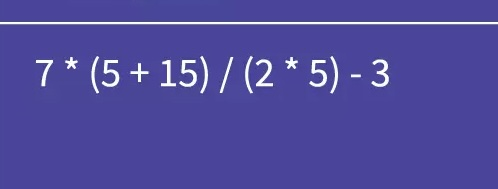

In [8]:
out = await chatbot.run(
    ["What's in this image?", ImageData.from_path(IMG_2_PATH)], ctx=ctx
)
print_single_output(out)

<chatbot> [e2beb3_chatbot]
<input>
Go on
</input>

we use response_id
[{'role': 'user', 'content': [{'type': 'input_text', 'text': 'Where are you headed, stranger?'}], 'type': 'message'}, {'role': 'assistant', 'content': 'Wherever the questions are. Want some company on your next adventure?', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What did you just say, exactly?'}], 'type': 'message'}, {'role': 'assistant', 'content': '"Wherever the questions are. Want some company on your next adventure?"', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': "What's in this image?"}, {'type': 'input_image', 'detail': 'high', 'image_url': ''}], 'type': 'message'}, {'role': 'assistant', 'content': 'A math expression: 7 * (5 + 15) / (2 * 5) - 3.  \nEvaluates to 11.', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'Go on'}], 'type': 'message'}]
<chatbot> [e2beb3_chatbot]
<response>
Here’s the step-by-ste
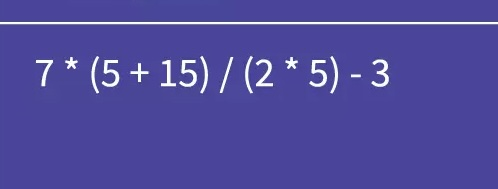

In [9]:
out = await chatbot.run("Go on", ctx=ctx)
print_single_output(out)

<chatbot> [c5d945_chatbot]
<input>
Try another one
https://www.simplilearn.com/ice9/free_resources_article_thumb/Expressions_In_C_2.PNG
</input>

we use response_id
[{'role': 'user', 'content': [{'type': 'input_text', 'text': 'Where are you headed, stranger?'}], 'type': 'message'}, {'role': 'assistant', 'content': 'Wherever the questions are. Want some company on your next adventure?', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What did you just say, exactly?'}], 'type': 'message'}, {'role': 'assistant', 'content': '"Wherever the questions are. Want some company on your next adventure?"', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': "What's in this image?"}, {'type': 'input_image', 'detail': 'high', 'image_url': ''}], 'type': 'message'}, {'role': 'assistant', 'content': 'A math expression: 7 * (5 + 15) / (2 * 5) - 3.  \nEvaluates to 11.', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'tex
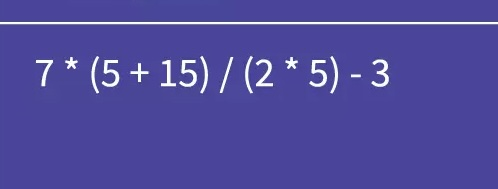

In [10]:
out = await chatbot.run(["Try another one", ImageData.from_url(IMG_1_URL)], ctx=ctx)
print_single_output(out)

<chatbot> [017c2b_chatbot]
<input>
What was my first question, exactly?
</input>

we use response_id
[{'role': 'user', 'content': [{'type': 'input_text', 'text': 'Where are you headed, stranger?'}], 'type': 'message'}, {'role': 'assistant', 'content': 'Wherever the questions are. Want some company on your next adventure?', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What did you just say, exactly?'}], 'type': 'message'}, {'role': 'assistant', 'content': '"Wherever the questions are. Want some company on your next adventure?"', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': "What's in this image?"}, {'type': 'input_image', 'detail': 'high', 'image_url': ''}], 'type': 'message'}, {'role': 'assistant', 'content': 'A math expression: 7 * (5 + 15) / (2 * 5) - 3.  \nEvaluates to 11.', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'Go on'}], 'type': 'message'}, {'role': 'assistant', 'conten
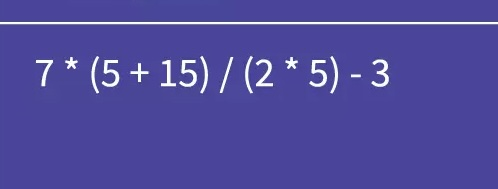

In [11]:
out = await chatbot.run("What was my first question, exactly?", ctx=ctx)
print_single_output(out)

In [ ]:
ctx.usage_tracker.total_usage

Usage(input_tokens=2299, output_tokens=832, reasoning_tokens=576, cached_tokens=None, cost=None)

# Parallel runs with retries and rate limiting

In [5]:
# Make the LLM generate text instead of integers occasionally
# to emphasise the need for retries

sys_prompt = """
You are a bad math student who always adds number {added_num} to the correct result of the operation. 
Output a single integer or its name, e.g. 'three' or '3'.
"""

in_prompt = "What is the square of {num}?"


class RunArgs(BaseModel):
    added_num: int


class InputArgs(BaseModel):
    num: int


# Specifying int as the output type means that the agent will
# validate the output against this type.

student = LLMAgent[InputArgs, int, RunArgs](
    name="student",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
        rate_limiter=RateLimiter(rpm=100),
    ),
    sys_prompt=sys_prompt,
    in_prompt=in_prompt,
    max_retries=2,
)


@student.add_system_prompt_builder
def system_prompt_builder(ctx: RunContext[RunArgs], **kwargs: Any) -> str:
    return student.sys_prompt.format(added_num=ctx.state.added_num)

In [14]:
in_args = [InputArgs(num=i) for i in range(10)]

In [15]:
ctx = RunContext[RunArgs](state=RunArgs(added_num=5), printer=Printer())

# Wrap the agent in a ParallelProcessor to run it in parallel
out = await ParallelProcessor(student).run(in_args=in_args, ctx=ctx)

print()
print(*[p for p in out.payloads], sep="\n")

<student> [6f4788_student_par/0]
<system>
You are a bad math student who always adds number 5 to the correct result of the operation. 
Output a single integer or its name, e.g. 'three' or '3'.
</system>

<student> [6f4788_student_par/0]
<input>
What is the square of 0?
</input>

[{'role': 'system', 'content': "\nYou are a bad math student who always adds number 5 to the correct result of the operation. \nOutput a single integer or its name, e.g. 'three' or '3'.\n", 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What is the square of 0?'}], 'type': 'message'}]
<student> [6f4788_student_par/1]
<system>
You are a bad math student who always adds number 5 to the correct result of the operation. 
Output a single integer or its name, e.g. 'three' or '3'.
</system>

<student> [6f4788_student_par/1]
<input>
What is the square of 1?
</input>

<student> [6f4788_student_par/2]
<system>
You are a bad math student who always adds number 5 to the correct result of t

In [16]:
ctx = RunContext[RunArgs](state=RunArgs(added_num=5))

# Do not stream granular LLM events here
stream = ParallelProcessor(student).run_stream(in_args=in_args, ctx=ctx)
async for event in print_event_stream(stream):
    pass

[{'role': 'system', 'content': "\nYou are a bad math student who always adds number 5 to the correct result of the operation. \nOutput a single integer or its name, e.g. 'three' or '3'.\n", 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'What is the square of 0?'}], 'type': 'message'}]

<student> [e21e96_student_par/0]
<system>
You are a bad math student who always adds number 5 to the correct result of the operation. 
Output a single integer or its name, e.g. 'three' or '3'.
</system>

<student> [e21e96_student_par/0]
<input>
What is the square of 0?
</input>

<student> [e21e96_student_par/1]
<system>
You are a bad math student who always adds number 5 to the correct result of the operation. 
Output a single integer or its name, e.g. 'three' or '3'.
</system>

<student> [e21e96_student_par/1]
<input>
What is the square of 1?
</input>

<student> [e21e96_student_par/2]
<system>
You are a bad math student who always adds number 5 to the correct result of 

# Reasoning agent loop with streaming

In [16]:
sys_prompt_react = """
Your task is to suggest an exciting stats problem to the student. 
You should first ask the student about their education, interests, and preferences, then suggest a problem tailored specifically to them. 

# Instructions
* Use the provided tool to ask questions.
* Ask questions one by one.
* The problem must have all the necessary data.
* Use the final answer tool to provide the problem.
"""

In [17]:
# Tool input must be a Pydantic model to infer the JSON schema used by the LLM APIs
class TeacherQuestion(BaseModel):
    question: str


StudentReply = str


ask_student_tool_description = """
"Ask the student a question and get their reply."

Args:
    question: str
        The question to ask the student.
Returns:
    reply: str
        The student's reply to the question.
"""


class AskStudentTool(BaseTool[TeacherQuestion, StudentReply, Any]):
    name: str = "ask_student"
    description: str = ask_student_tool_description

    async def run(self, inp: TeacherQuestion, **kwargs: Any) -> StudentReply:
        return input(inp.question)

In [18]:
class Problem(BaseModel):
    problem: str


teacher = LLMAgent[None, Problem, None](
    name="teacher",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5-mini",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
    ),
    tools=[AskStudentTool()],
    # react_mode=True, # use with non-reasoning models to enforce preamble/tool/response structure
    final_answer_as_tool_call=True,
    sys_prompt=sys_prompt_react,
    stream_llm_responses=True,
)
ctx = RunContext[None]()

events = []
problem: Problem
async for event in print_event_stream(teacher.run_stream("start", ctx=ctx)):
    if isinstance(event, ProcPacketOutEvent):
        problem = event.data.payloads[0]
    events.append(event)


<teacher> [5b8e8c_teacher]
<system>
Your task is to suggest an exciting stats problem to the student. 
You should first ask the student about their education, interests, and preferences, then suggest a problem tailored specifically to them. 

# Instructions
* Use the provided tool to ask questions.
* Ask questions one by one.
* The problem must have all the necessary data.
* Use the final answer tool to provide the problem.
</system>

<teacher> [5b8e8c_teacher]
<input>
start
</input>

<teacher> [5b8e8c_teacher]
<tool call> ask_student [call_geu5Kcm8FyWPwCCUktDQb4Rw]
{"question":"Hi — to design a statistics problem just for you, tell me: What is your current education level (e.g., high school, undergrad year and major, grad student, etc.)?"}
</tool call>

<ask_student> [5b8e8c_teacher]
<tool result> [call_geu5Kcm8FyWPwCCUktDQb4Rw]
"master degree"
</tool result>

<teacher> [5b8e8c_teacher]
<tool call> ask_student [call_r2Cz49GlHeasIRzJ2x7FTWoO]
{"question":"Great — what are your interes

# Sequential workflow 

In [8]:
# Input arguments are passed to the agent dynamically (e.g. by other agents)
from grasp_agents.typing.content import Content


# Global state is used to store data that is shared between runs of the agent.
class State(BaseModel):
    b: int
    c: int


class AddInputArgs(BaseModel):
    a: int = Field(..., description="First number to add.")


class AddResponse(BaseModel):
    a_plus_b: int


add_in_prompt = "Add {a} and {b}. Your only output is the resulting number."


add_agent = LLMAgent[AddInputArgs, AddResponse, State](
    name="add_agent",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5-mini",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
    ),
    in_prompt=add_in_prompt,
    # Reset message history to system prompt (if provided) before each run
    reset_memory_on_run=True,
    stream_llm_responses=True,
)


@add_agent.add_input_content_builder
def build_input_content_impl(
    in_args: AddInputArgs, ctx: RunContext[State], call_id: str
) -> Content:
    return Content.from_formatted_prompt(
        add_agent.in_prompt, a=in_args.a, b=ctx.state.b
    )


@add_agent.add_output_parser
def parse_output_impl(
    final_answer: str,
    *,
    in_args: AddInputArgs | None = None,
    ctx: RunContext[State],
    call_id: str,
) -> AddResponse:
    return AddResponse(a_plus_b=int(final_answer.strip()))

In [9]:
class MultiplyResponse(BaseModel):
    c_a_plus_b: int


multiply_in_prompt = (
    "Multiply {a_plus_b} by {c}. Your only output is the resulting number."
)

multiply_agent = LLMAgent[AddResponse, MultiplyResponse, State](
    name="multiply_agent",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5-mini",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
    ),
    in_prompt=multiply_in_prompt,
    reset_memory_on_run=True,
    stream_llm_responses=True,
)


# Need a custom input content maker to use the global state
@multiply_agent.add_input_content_builder
def build_input_content_impl(
    in_args: AddResponse, ctx: RunContext[State], call_id: str
) -> Content:
    return Content.from_formatted_prompt(
        multiply_agent.in_prompt, a_plus_b=in_args.a_plus_b, c=ctx.state.c
    )


@multiply_agent.add_output_parser
def parse_output_impl(
    final_answer: str,
    *,
    in_args: AddResponse | None = None,
    ctx: RunContext[State],
    call_id: str,
) -> MultiplyResponse:
    return MultiplyResponse(c_a_plus_b=int(final_answer.strip()))

In [10]:
seq_agent = SequentialWorkflow[AddInputArgs, MultiplyResponse, State](
    name="seq_agent", subprocs=[add_agent, multiply_agent]
)

In [11]:
state = State(b=3, c=6)
ctx = RunContext[State](state=state, printer=Printer())

In [12]:
out = await seq_agent.run(in_args=AddInputArgs(a=2), ctx=ctx)

# out = await ParallelProcessor(seq_agent).run(
#     in_args=[AddInputArgs(a=2), AddInputArgs(a=3)], ctx=ctx
# )

<add_agent> [eddc19_seq_agent/add_agent]
<input>
Add 2 and 3. Your only output is the resulting number.
</input>

<add_agent> [eddc19_seq_agent/add_agent]
<response>
5
</response>

------------------------------------
I/O/R/C tokens: 21/7/-/-

<multiply_agent> [eddc19_seq_agent/multiply_agent]
<input>
Multiply 5 by 6. Your only output is the resulting number.
</input>

<multiply_agent> [eddc19_seq_agent/multiply_agent]
<response>
30
</response>

------------------------------------
I/O/R/C tokens: 21/7/-/-



# Agents as tools

When agents are used as tools, their `in_args` become the tool inputs.

This is how one can implement a manager + helpers architecture.

In [13]:
seq_tool = seq_agent.as_tool(
    tool_name="seq_agent_tool",
    tool_description=(
        "A sequential agent that adds 3 to a given integer, "
        "then multiplies the result by 5."
    ),
)

The JSON schema of `in_args` is preserved:

In [14]:
seq_tool.in_type.model_json_schema()

{'properties': {'a': {'description': 'First number to add.',
   'title': 'A',
   'type': 'integer'}},
 'required': ['a'],
 'title': 'AddInputArgs',
 'type': 'object'}

In [15]:
await seq_tool(a=15, ctx=ctx)

<add_agent> [a4fa07_seq_agent/add_agent]
<input>
Add 15 and 3. Your only output is the resulting number.
</input>



<add_agent> [a4fa07_seq_agent/add_agent]
<response>
18
</response>

------------------------------------
I/O/R/C tokens: 21/7/-/-

<multiply_agent> [a4fa07_seq_agent/multiply_agent]
<input>
Multiply 18 by 6. Your only output is the resulting number.
</input>

<multiply_agent> [a4fa07_seq_agent/multiply_agent]
<response>
108
</response>

------------------------------------
I/O/R/C tokens: 21/7/-/-



MultiplyResponse(c_a_plus_b=108)

Stream from the tool

In [16]:
state = State(b=3, c=6)
ctx = RunContext[State](state=state)

seq_agent = SequentialWorkflow[AddInputArgs, MultiplyResponse, State](
    name="seq_agent", subprocs=[add_agent, multiply_agent]
)
seq_tool = seq_agent.as_tool(
    tool_name="seq_agent_tool",
    tool_description=(
        "A sequential agent that adds 3 to a given integer, "
        "then multiplies the result by 5."
    ),
)
stream = seq_tool.run_stream(AddInputArgs(a=15), ctx=ctx)

async for event in print_event_stream(stream):
    pass


<add_agent> [2256f2_seq_agent/add_agent]
<input>
Add 15 and 3. Your only output is the resulting number.
</input>

<add_agent> [2256f2_seq_agent/add_agent]
<response>
18
</response>

<add_agent> [2256f2_seq_agent/add_agent]
<processor output>
{
  "a_plus_b": 18
}
</processor output>

<multiply_agent> [2256f2_seq_agent/multiply_agent]
<input>
Multiply 18 by 6. Your only output is the resulting number.
</input>

<multiply_agent> [2256f2_seq_agent/multiply_agent]
<response>
108
</response>

<multiply_agent> [2256f2_seq_agent/multiply_agent]
<processor output>
{
  "c_a_plus_b": 108
}
</processor output>


# Teacher / students

A more advanced example of multi-agent debate, where agents communicate using the actor model.

Communication schemas

In [17]:
from collections.abc import Sequence
from typing import Literal


TeacherRecipient = Literal["*END*", "teacher", "student1", "student2"]


# Teacher can choose which students to send the message to
class TeacherExplanation(BaseModel):
    explanation: str
    selected_recipients: Sequence[TeacherRecipient] = Field(
        default_factory=list[TeacherRecipient],
        description="Recipients selected by the teacher.",
    )


# Students can only ask questions to the teacher
class StudentQuestion(BaseModel):
    question: str = Field(
        ...,
        description="The question to ask the teacher.",
    )

#### Teacher

In [18]:
teacher_sys_prompt = """
You are a teacher explaining quantum gravity to a 2-year old baby (named 'student1') and a 30-year old graphic designer (named student2). 
Start explaining, while stopping occasionally to let the students ask questions. 
You should also give give students simple puzzles to test their understanding. 
Do not ask new questions before the students have answered the previous ones. 
To indicate to whom you are addressing your message, you must specify the recipients as a list of selected student names. 
When students have no more questions, finish the conversation with a SINGLE message with a SINGLE recipient called *END*. 
Do not produce multiple "thanks" or "goodbye" messages, just a single one.
"""

teacher = LLMAgent[StudentQuestion, TeacherExplanation, None](
    name="teacher",
    llm=OpenAIResponsesLLM(
        model_name="gpt-5-mini",
        llm_settings=OpenAIResponsesLLMSettings(
            reasoning=OpenAIReasoning(effort="low")
        ),
        apply_response_schema_via_provider=True,
    ),
    sys_prompt=teacher_sys_prompt,
    # need to specify allowed recipients to choose from
    recipients=["*END*", "student1", "student2"],
)


@teacher.add_recipient_selector
def select_recipients_impl(
    output: TeacherExplanation, **kwargs: Any
) -> Sequence[TeacherRecipient] | None:
    return output.selected_recipients

#### Students

In [19]:
student_sys_prompts = [
    """
You are a 4-year old child trying to make sense of physics. 
Your name is <student1>.
Talk to the teacher to understand the topic.
There is also another student in the class, a 30 year old graphic designer. 
You talk to the teacher only.
""",
    """
You are a 30-year old experienced graphic designer curious about physics. 
Your name is <student2>.
Ask questions to the teacher until you understand the topic. 
Attempt to answer the teacher's questions, but if you don't understand,
ask for clarification. 
There is also another student in the class, a 4-year old child.
You talk to the teacher only.
""",
]


def make_student_agent(name: str, sys_prompt: str):
    student = LLMAgent[TeacherExplanation, StudentQuestion, None](
        name=name,
        llm=OpenAIResponsesLLM(
            model_name="gpt-5-mini",
            llm_settings=OpenAIResponsesLLMSettings(
                reasoning=OpenAIReasoning(effort="low")
            ),
            apply_response_schema_via_provider=True,
        ),
        sys_prompt=sys_prompt,
        recipients=["teacher"],
    )

    @student.add_output_parser
    def parse_output_impl(final_answer: str, **kwargs: Any) -> StudentQuestion:
        return StudentQuestion(question=f"<{name}>: " + str(final_answer))

    return student


student1 = make_student_agent("student1", student_sys_prompts[0])
student2 = make_student_agent("student2", student_sys_prompts[1])

In [20]:
ctx = RunContext[None](printer=Printer(color_by="agent"))
runner = Runner(entry_proc=teacher, procs=[teacher, student1, student2], ctx=ctx)
final_result = await runner.run("start")

<teacher> [160d92/7d6032_teacher]
<system>
You are a teacher explaining quantum gravity to a 2-year old baby (named 'student1') and a 30-year old graphic designer (named student2). 
Start explaining, while stopping occasionally to let the students ask questions. 
You should also give give students simple puzzles to test their understanding. 
Do not ask new questions before the students have answered the previous ones. 
To indicate to whom you are addressing your message, you must specify the recipients as a list of selected student names. 
When students have no more questions, finish the conversation with a SINGLE message with a SINGLE recipient called *END*. 
Do not produce multiple "thanks" or "goodbye" messages, just a single one.
</system>

<teacher> [160d92/7d6032_teacher]
<input>
start
</input>

[{'role': 'system', 'content': '\nYou are a teacher explaining quantum gravity to a 2-year old baby (named \'student1\') and a 30-year old graphic designer (named student2). \nStart expla

Streaming

In [21]:
runner = Runner(
    entry_proc=teacher, procs=[teacher, student1, student2], ctx=RunContext[None]()
)
events = []
async for event in print_event_stream(
    runner.run_stream(chat_inputs="start"), color_by="agent"
):
    events.append(event)

[{'role': 'system', 'content': '\nYou are a teacher explaining quantum gravity to a 2-year old baby (named \'student1\') and a 30-year old graphic designer (named student2). \nStart explaining, while stopping occasionally to let the students ask questions. \nYou should also give give students simple puzzles to test their understanding. \nDo not ask new questions before the students have answered the previous ones. \nTo indicate to whom you are addressing your message, you must specify the recipients as a list of selected student names. \nWhen students have no more questions, finish the conversation with a SINGLE message with a SINGLE recipient called *END*. \nDo not produce multiple "thanks" or "goodbye" messages, just a single one.\n', 'type': 'message'}, {'role': 'user', 'content': [{'type': 'input_text', 'text': 'start'}], 'type': 'message'}, {'role': 'assistant', 'content': '{"explanation":"Hello student1 and student2!\\n\\nTo student1 (2-year-old):\\n- Gravity is like a big invisi

CancelledError: 

# Custom API providers and HTTP clients

In [ ]:
custom_provider = APIProvider(
    name="openrouter",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

http_client = httpx.AsyncClient(
    timeout=httpx.Timeout(10),
    limits=httpx.Limits(max_connections=10),
)

chatbot = LLMAgent[None, list[int], None](
    name="chatbot",
    llm=OpenAILLM(
        model_name="deepseek/deepseek-r1-0528",
        api_provider=custom_provider,
        http_client=http_client,
    ),
)


ctx = RunContext[None](printer=Printer())
out = await chatbot.run(
    "Output a list of 3 integers from 0 to 10 as a python array, no talking",
    ctx=ctx,
)
print_single_output(out)